# Copyright Netherlands eScience Center <br>
**Function     : Check the data for publication ** <br>
**Author       : Yang Liu** <br>
**First Built   : 2020.02.02** <br>
**Last Update   : 2020.02.02** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to check the model outputs from vector auto-regressive model and BayesLSTM.<br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv

sys.path.append("/mnt/e/Creator_Zone/Script_craft/ML4Climate/Scripts/DLACs")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import matplotlib
import matplotlib.pyplot as plt

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
ಠ_ಠ = "I'm a valid variable name!"
print(ಠ_ಠ)
# model type
model_type = 'lorenz84ex' # choose lorenz84 / lorenz84ex / lorenz84AA
# datapath for output
output_path = '/mnt/e/Creator_Zone/Paper/Bayesian_Lorenz_paper/data_paper'
# data path of experiment
datapath_BayesLSTM = '/mnt/e/Creator_Zone/Paper/Bayesian_Lorenz_paper/data_paper'
datapath_VAR = '/mnt/e/Creator_Zone/Paper/Bayesian_Lorenz_paper/data_paper'

I'm a valid variable name!


In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 4200
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 1800

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
original model<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
with periodic forcing<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>
with AA effect<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4, alpha = 0.025, beta = 0.00625** <br>
========================================================================================================<br>
##### AR
The methods include AR and VAR, which are based on <br>
Lütkepohl, H. (2005). New introduction to multiple time series analysis. Springer Science & Business Media.<br>
========================================================================================================<br>



In [5]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 0.4):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

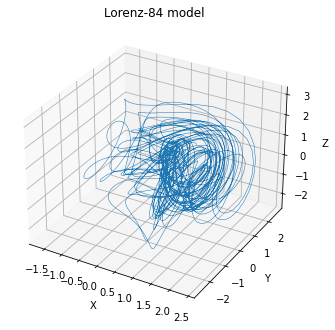

<Figure size 432x288 with 0 Axes>

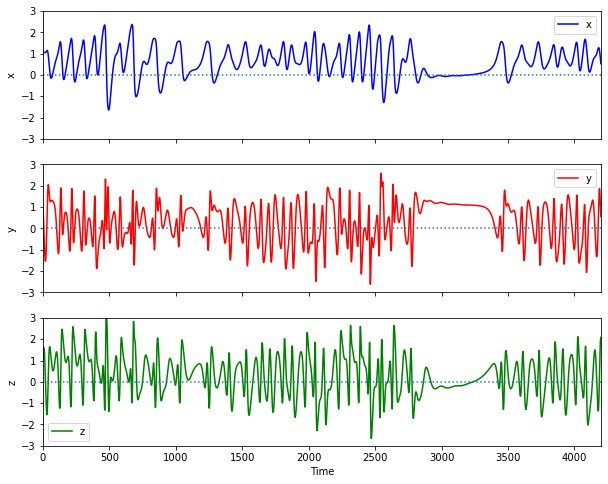

In [7]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                 ###########
    #################################################################################
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Time")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

In [8]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    # maximum and minimum
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    # std -> only consider the validation time
    x_std = np.std(x[-test_len:])
    y_std = np.std(y[-test_len:])
    z_std = np.std(z[-test_len:])
    
    x_std_full = np.std(x[:])
    y_std_full = np.std(y[:])
    z_std_full = np.std(z[:])

    # build the input data structure
    series_full = np.zeros((3, num_steps), dtype=float)
    series_full[0,:] = x[:]
    series_full[1,:] = y[:]
    series_full[2,:] = z[:]
    
    #series_train = series_full[:,:-test_len]
    #series_test = series_full[:,-test_len:]
    
    print("std - validation time")
    print("x", x_std)
    print("y", y_std)
    print("z", z_std)
    print("std - full series")
    print("x", x_std_full)
    print("y", y_std_full)
    print("z", z_std_full)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================
std - validation time
x 0.6375789869437326
y 0.8998329144374558
z 0.8236274756564372
std - full series
x 0.6676600767475926
y 0.8994888751762761
z 0.9177685982494913


In [9]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    bayes_step_lead = 60 # unit time step
    var_step_lead = 60 # unit time step
    # number of ensembles
    ens = 20
    predictand_bayes = np.zeros((ens, 3, test_len, bayes_step_lead), dtype=float)
    predictand_var = np.zeros((ens, 3, test_len, var_step_lead), dtype=float)
    for i in range(ens):
        dataset_pred_bayes = Dataset(os.path.join(datapath_BayesLSTM, 'original', 'pred_lorenz84_ens_{}_per1t.nc'.format(i)))
        dataset_pred_var = Dataset(os.path.join(datapath_VAR, 'original', 'VAR_pred_lorenz84_member_{}_per1t.nc'.format(i)))
        predictand_bayes[i,:,:,:] = dataset_pred_bayes.variables['series'][:]
        predictand_var[i,:,:,:] = dataset_pred_var.variables['series'][:]     
    print(predictand_bayes.shape)
    print(predictand_var.shape)

*******************  load ensemble data  *********************
(20, 3, 1800, 60)
(20, 3, 1800, 60)


In [11]:
    ###################################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing with longer series      ###########
    ###################################################################################################
    step_lead_check = 60
    num_steps_long = num_steps + step_lead_check
    # Need one more for the initial values
    xx = np.empty(num_steps_long)
    yy = np.empty(num_steps_long)
    zz = np.empty(num_steps_long)
    tt = 0.0
    
    # save initial values
    xx[0] = x_init
    yy[0] = y_init
    zz[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps_long-1):
        dx, dy, dz = lorenz84_ex(xx[i], yy[i], zz[i], tt, a, b ,F, G, epsilon)
        xx[i + 1] = xx[i] + (dx * dt)
        yy[i + 1] = yy[i] + (dy * dt)
        zz[i + 1] = zz[i] + (dz * dt)
        tt += dt

In [12]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    step_lead_calc = 60
    # lead time dependent CRPS
    crps_VAR = np.zeros((step_lead_check+1,3), dtype=float)
    crps_bayes = np.zeros((step_lead_check+1,3), dtype=float)
    
    for i in range(step_lead_calc):
        _, crps_VAR[i+1,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead_check)+i:-step_lead_check+i], predictand_var[:,0,:,i])
        _, crps_VAR[i+1,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead_check)+i:-step_lead_check+i], predictand_var[:,1,:,i])
        _, crps_VAR[i+1,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead_check)+i:-step_lead_check+i], predictand_var[:,2,:,i])
        
        _, crps_bayes[i+1,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead_check)+i:-step_lead_check+i],
                                                 predictand_bayes[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_bayes[i+1,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead_check)+i:-step_lead_check+i],
                                                 predictand_bayes[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_bayes[i+1,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead_check)+i:-step_lead_check+i],
                                                 predictand_bayes[:,2,:,i]* (z_max - z_min) + z_min)     

<Figure size 432x288 with 0 Axes>

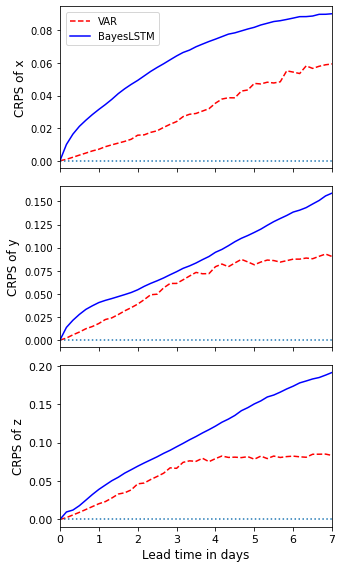

In [13]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    display_upto = 42
        
    index = np.arange(0, step_lead_check)
    
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(4.8, 8, forward=True)
    
    # forecast
    ax1.plot(np.arange(display_upto+1), crps_VAR[:display_upto+1,0], color='r', linestyle='dashed', label='VAR')
    ax1.plot(np.arange(display_upto+1), crps_bayes[:display_upto+1,0], color='b', label='BayesLSTM')
    
    ax2.plot(np.arange(display_upto+1), crps_VAR[:display_upto+1,1], color='r', linestyle='dashed', label='VAR')
    ax2.plot(np.arange(display_upto+1), crps_bayes[:display_upto+1,1], color='b', label='BayesLSTM')
    
    ax3.plot(np.arange(display_upto+1), crps_VAR[:display_upto+1,2], color='r', linestyle='dashed', label='VAR')
    ax3.plot(np.arange(display_upto+1), crps_bayes[:display_upto+1,2], color='b', label='BayesLSTM')

    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, display_upto)
    ax2.set_xlim(0, display_upto)
    ax3.set_xlim(0, display_upto)
    
    ax1.set_xticks(np.arange(0,display_upto+1,6))
    ax2.set_xticks(np.arange(0,display_upto+1,3))
    ax3.set_xticks(np.arange(0,display_upto+1,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("CRPS of x", fontsize=12)
    ax2.set_ylabel("CRPS of y", fontsize=12)
    ax3.set_ylabel("CRPS of z", fontsize=12)
    
    plt.xlabel("Lead time in days", fontsize=12)
    
    plt.xticks(np.arange(0,display_upto+1,6),np.arange(0,display_upto//6+1),fontsize=11)
    plt.yticks(fontsize=11)    

    ax1.legend(frameon=True, bbox_to_anchor=(0.005,0.995), prop={'size': 10.0}, loc=2)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    #ax3.legend(frameon=True, bbox_to_anchor=(0.995,0.005), prop={'size': 10.0}, loc=4)
    
    plt.tight_layout()

    plt.show()

In [14]:
    # save netCDF - BayesLSTM
    for i in range(ens):
        data_wrap = Dataset(os.path.join(output_path,'BayesLSTM_pred_lorenz84_ens_member_{}_ex_per1t.nc'.format(i)), 'w',format = 'NETCDF4')
        var, time, lead = predictand_bayes[i,:,:,:].shape
        # create dimensions for netcdf data
        var_wrap_dim = data_wrap.createDimension('var',var)
        time_wrap_dim = data_wrap.createDimension('time',time)
        lead_wrap_dim = data_wrap.createDimension('lead',lead)    
        # create 1-dimension variables
        var_wrap_var = data_wrap.createVariable('var',np.int32,('var',))
        time_wrap_var = data_wrap.createVariable('time',np.int32,('time',))
        lead_wrap_var = data_wrap.createVariable('lead',np.int32,('lead',))
        # create 3-dimension variables
        series_wrap_var = data_wrap.createVariable('series',np.float32,('var', 'time', 'lead'))
        # global attributes
        data_wrap.description = 'Lead time dependent Lorenz 84 forecast with BayesLSTM'
        # variable attributes
        var_wrap_var.units = '1'
        time_wrap_var.units = '1'
        lead_wrap_var.units = '1'

        var_wrap_var.long_name = 'variables'
        time_wrap_var.long_name = 'valid time'
        lead_wrap_var.long_name = 'lead time'
        # writing data
        var_wrap_var[:] = np.arange(var)
        time_wrap_var[:] = np.arange(time)
        lead_wrap_var[:] = np.arange(lead)
        series_wrap_var[:] = predictand_bayes[i,:,:,:]
        # close the file
        data_wrap.close()
        print("Create netcdf files successfully!!")

Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!


In [15]:
    # save netCDF - VAR
    for i in range(ens):
        data_wrap = Dataset(os.path.join(output_path,'VAR_pred_lorenz84_ens_member_{}_ex_per1t.nc'.format(i)), 'w',format = 'NETCDF4')
        var, time, lead = predictand_var[i,:,:,:].shape
        # create dimensions for netcdf data
        var_wrap_dim = data_wrap.createDimension('var',var)
        time_wrap_dim = data_wrap.createDimension('time',time)
        lead_wrap_dim = data_wrap.createDimension('lead',lead)    
        # create 1-dimension variables
        var_wrap_var = data_wrap.createVariable('var',np.int32,('var',))
        time_wrap_var = data_wrap.createVariable('time',np.int32,('time',))
        lead_wrap_var = data_wrap.createVariable('lead',np.int32,('lead',))
        # create 3-dimension variables
        series_wrap_var = data_wrap.createVariable('series',np.float32,('var', 'time', 'lead'))
        # global attributes
        data_wrap.description = 'Lead time dependent Lorenz 84 forecast with BayesLSTM'
        # variable attributes
        var_wrap_var.units = '1'
        time_wrap_var.units = '1'
        lead_wrap_var.units = '1'

        var_wrap_var.long_name = 'variables'
        time_wrap_var.long_name = 'valid time'
        lead_wrap_var.long_name = 'lead time'
        # writing data
        var_wrap_var[:] = np.arange(var)
        time_wrap_var[:] = np.arange(time)
        lead_wrap_var[:] = np.arange(lead)
        series_wrap_var[:] = predictand_var[i,:,:,:]
        # close the file
        data_wrap.close()
        print("Create netcdf files successfully!!")

Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
Create netcdf files successfully!!
